# Data Science for Networks

In [1]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
import time

#### Stock pre-processing

In [2]:
def _date_parser(x):
    return pd.to_datetime(x, yearfirst=True, format='%Y-%m-%d')

data_dir = 'historical-prices'
files = os.listdir(data_dir)
files.sort()
len(files)

502

Retain only stocks whose series are complete between year-X and year-Y.

In [3]:
desired_size = 251 # 503 for 2016+2017
stock_series = []
for file in files:
    df = pd.read_csv(os.path.join(data_dir, file), header=0, index_col=0, parse_dates=True, 
                     date_parser=_date_parser)    
    s = df.loc['2017':'2017', 'Close']
    s.name = file.split('_')[0]
    # print(s.size)
    if s.size == desired_size:
        stock_series += [s]
len(stock_series)

501

Find relative difference with respect to the previous day.

In [4]:
diffs = [s.diff() for s in stock_series]
pdiffs = [s.diff() / s.shift(1) for s in stock_series]
pdiffs = [s[1:] for s in pdiffs]
pdiffs = pdiffs[:-1]

stock_to_id = {}
id_to_stock = {}
for stock in pdiffs:
    stock_to_id[stock.name] = len(stock_to_id)
    id_to_stock[len(stock_to_id) - 1] = stock.name

#### Define tensor and decompose

In [5]:
# tensor shape
r_len = c_len = len(pdiffs)
t_len = pdiffs[0].size
r_len, c_len, t_len

(500, 500, 250)

Numpy implementation -> large memory consumption ?

In [6]:
import numpy as np

In [9]:
X = np.zeros(shape=(r_len, c_len, t_len))

# growth threshold
tr = 0.01

start_time = time.time()
for t in range(t_len):
    print('\rt: {}/{}'.format(t+1, t_len), end='')
    for i, item_i in enumerate(pdiffs):
        
        # use symmetry
        for j in range(i+1):
            # print(i, j)
            if i == j:
                X[i][j][t] = 0
                continue
            
            item_j = pdiffs[j]
            if item_i.iloc[t] > tr and item_j.iloc[t] > tr:
                X[i][j][t] = 1
                X[j][i][t] = 1
            else:
                X[i][j][t] = 0
print()
print('elapsed {} secs'.format(int(time.time() - start_time)))      

t: 249/250elapsed 183 secs


In [13]:
import tensorly as tl
from tensorly.decomposition import parafac, non_negative_parafac

TX = tl.tensor(X)

Decompose evaluating (time) and MSE give a number **R** of components.

In [18]:
import math

start_time = time.time()

times = []
errors = []
for r in range(1, 101):
    A, B, C = parafac(TX, r)
    sec = int(time.time() - start_time)
    
    TX_H = np.einsum('ir,jr,kr->ijk', A, B, C, optimize=True)
    err = TX - TX_H
    err = math.pow(np.linalg.norm(err), 2)
    
    print(r, 'elapsed:', sec, err)
    times += [sec]
    errors += [err]

# for r in range(1, t_len + 1):
#     start_time = time.time()
#     A, B, C = parafac(TX, r)
#     print('elapsed: ', int(time.time() - start_time))
    
    # use non-negative parafact decomposition
    # start_time = time.time()
    # A, B, C = nnpar(NPX, r)
    # print('elapsed: ', int(time.time() - start_time))

1 elapsed:  3 2245026.3935451806
2 elapsed:  31 2169174.25539474
3 elapsed:  56 2100419.327487269
4 elapsed:  107 2044895.2946105453
5 elapsed:  143 1995854.1075234357
6 elapsed:  181 1951252.5264304136
7 elapsed:  228 1910379.8105484943
8 elapsed:  272 1862881.152684178
9 elapsed:  319 1821553.802805954
10 elapsed:  396 1784531.0086555453
11 elapsed:  443 1743674.0624196199
12 elapsed:  491 1705471.8277120457
13 elapsed:  531 1669088.366138607
14 elapsed:  582 1638175.0941014115
15 elapsed:  625 1604136.2427617796
16 elapsed:  668 1570984.3886461079
17 elapsed:  704 1541032.9206447534
18 elapsed:  745 1513267.2225004856
19 elapsed:  787 1483704.4352802308
20 elapsed:  844 1456496.0005878701
21 elapsed:  903 1427166.2360694362
22 elapsed:  971 1402003.6576070262
23 elapsed:  1022 1375510.6040231802
24 elapsed:  1065 1345630.925237944
25 elapsed:  1106 1320713.1165785652
26 elapsed:  1147 1294398.729899865
27 elapsed:  1190 1271094.558847383
28 elapsed:  1218 1247385.4595094107
29 elaps

In [20]:
for r in range(101, 201):
    A, B, C = parafac(TX, r)
    sec = int(time.time() - start_time)
    
    TX_H = np.einsum('ir,jr,kr->ijk', A, B, C, optimize=True)
    err = TX - TX_H
    err = math.pow(np.linalg.norm(err), 2)
    
    print(r, 'elapsed:', sec, err)
    times += [sec]
    errors += [err]

101 elapsed: 6805 441823.6253927126
102 elapsed: 6895 435545.98058485077
103 elapsed: 6987 428820.83294759446
104 elapsed: 7078 404655.0890420906
105 elapsed: 7170 412432.2590975276
106 elapsed: 7261 404807.24012341956
107 elapsed: 7355 391429.1815388876
108 elapsed: 7446 396435.8027395714
109 elapsed: 7539 390270.4922367608
110 elapsed: 7632 374390.5022883023
111 elapsed: 7727 367278.47188044013
112 elapsed: 7819 363097.93768570776
113 elapsed: 7913 355418.4006500145
114 elapsed: 8008 354056.71989037347
115 elapsed: 8103 344914.51123055856
116 elapsed: 8197 336850.51583737426
117 elapsed: 8292 329819.8590622124
118 elapsed: 8387 330186.21377187775
119 elapsed: 8483 326673.95721388474
120 elapsed: 8579 318201.0022517617
121 elapsed: 8676 309235.545601761
122 elapsed: 8772 302134.33104411315
123 elapsed: 8870 306846.76457789016
124 elapsed: 8966 291334.9703026552
125 elapsed: 9065 284728.28276851994
126 elapsed: 9163 285760.77596260194
127 elapsed: 9263 277479.01669868187
128 elapsed: 9

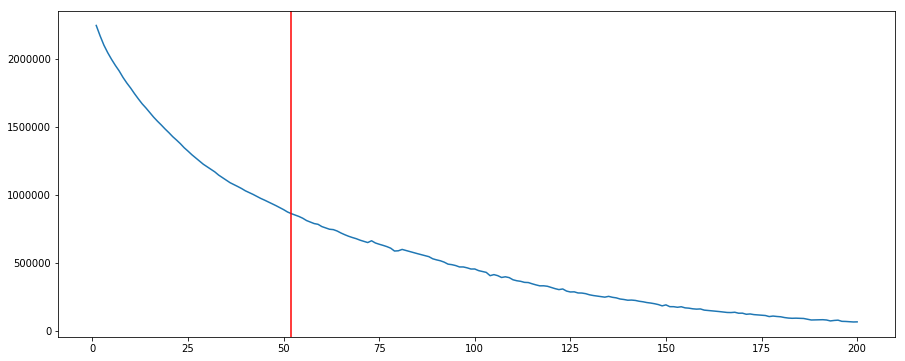

In [41]:
plt.rcParams['figure.figsize'] = [15, 6]
plt.plot(np.arange(1, 201), errors)
plt.axvline(x=52, color='r')
plt.savefig("errors_trend_line.png")
plt.show()

In [32]:
second_derivative = []

for j in range(1, 199):
    a = errors[j - 1] + errors[j + 1] - 2*errors[j]
    if a > 0:
        second_derivative += [a]
    else:
        0

np.argmax(second_derivative)

52

In [35]:
np_errors = np.array(errors)
np.save("R_errors", np_errors)

In [ ]:
for factor in range(5):
    plt.plot(list(C[:, factor]))
    plt.title('Factor {}'.format(factor))
    # print(A[:20, factor].data)
    # print(B[:20, factor].data)
    for a in A[:, factor].todense().argsort()[::-1][:5]:
        print(a,id_to_stock[a],A[a,factor])
        print(id_to_stock[a], end=' ')
        # print()
        # print()
    print('---')
    for b in B[:, factor].todense().argsort()[::-1][:5]:
        print(b,id_to_stock[b],B[b,factor])
        print(id_to_stock[b], end=' ')
        # print()
        # print()
    print()
    plt.show()
    print()
    print()